<a href="https://colab.research.google.com/github/Annalina-Luo/ClipNews/blob/main/ClipNews_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inference notenook for [ClipNews]((https://github.com/Annalina-Luo/NewsClip.git))

In [1]:
#@title Install
# you can upload the codes or clone them from github.
!git clone https://github.com/Annalina-Luo/ClipNews.git
!pip install transformers
!pip install git+https://github.com/openai/CLIP.git

Cloning into 'ClipNews'...
remote: Enumerating objects: 253, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 253 (delta 11), reused 2 (delta 1), pack-reused 230
Receiving objects: 100% (253/253), 19.63 MiB | 11.01 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-wt8rvhse
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-wt8rvhse
  Resolved https://github.com/open

In [2]:
cd ClipNews/

/content/ClipNews


In [3]:
#@title Download the training data and checkpoints for previous models
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

class Downloader(object):
    def __init__(self):
        self.authenticate()
        
    def authenticate(self):
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        self.drive = GoogleDrive(gauth)
    
    def download_file(self, file_id, file_dst):
        downloaded = self.drive.CreateFile({'id':file_id})
        downloaded.FetchMetadata(fetch_all=True)
        downloaded.GetContentFile(file_dst)

downloader = Downloader()

In [4]:
# it will take a long time to download our data (around 4 minutes)
downloader.download_file("1XQ1iAFs91jOtP6DiklAxnd3Mq7ZPGIrx", "./images_processed.tar.gz")
downloader.download_file("1e5WIAYMvrGbjw02eH0HkMbnBUo_Fapxa", "./test.json")
downloader.download_file("1pzuxjyMmvFPS_qk2Lfro-PkDbC6gTqj5", "./checkpoint/checkpoint_ClipNews.pth.tar")

In [5]:
# it will take a long time to upizp our data (around 2 minutes)
!tar -zxf ./images_processed.tar.gz

In [6]:
#@title Import packages
import time
import json
import skimage.io as io
from PIL import Image
import argparse
import torch
import torch.nn as nn
from tqdm import tqdm
from model import Encoder_text, Decoder, NewsTransformer, translate_sentence, ciderScore, CLIP_encoder
import os
import numpy as np
from utils import *
import torch.optim as optim
import clip
from transformers import RobertaTokenizer, RobertaModel
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # to use the pre-trained model, the GPU is needed
clip_model, preprocess = clip.load("ViT-B/32", device=device, jit=False)
clip_model.to(device)
text_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
text_model = RobertaModel.from_pretrained('roberta-base')
print("Done")

100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 125MiB/s]


Done


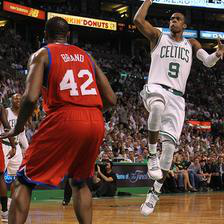

Article content 
 Celtics Gain Rematch Against James and Heat  BOSTON -- The chant started in the final minute. Boston Celtics fans could sense the moment, and they know what awaits them this week. "Beat the Heat!" came from one pocket of the crowd before spreading throughout the arena. A sign on the video screen read, "Bring on LeBron." The message was clear. Boston is ready for Goliath.  It took longer than Celtics fans expected when the series started, but Boston will finally have another chance at LeBron James and the Miami Heat in the Eastern Conference finals. The Celtics were extended to seven games in the conference semifinals by the eighth-seeded Philadelphia 76ers before holding on for an 85-75 victory in Saturday's deciding game.  Miami beat the Celtics in five games in last season's conference semifinals, as the Celtics' Rajon Rondo sustained a dislocated elbow in the series.  "We feel we can beat Miami," Rondo said. "Obviously, we got to this point, there's no doubt in our

In [17]:
#@title Load test data
import json
import PIL.Image as image
testdata_path = "./test.json"
testdata = json.load(open(testdata_path,"r"))
image_dir = "./images_processed/"

# show the image and article for the first data in test dataset
idx = 42 # choose one of news images
img = image.open(image_dir+testdata[idx]["image_path"])
img.show()
print("Article content \n", testdata[idx]["article"])

In [18]:
#@title Data Preprocessing

# Image
image_path = os.path.join(image_dir, testdata[idx]["image_path"])
image = io.imread(image_path)
pil_image = Image.fromarray(image)
image_input = preprocess(pil_image)
images = torch.Tensor(image_input).unsqueeze(0)

# Article
article = testdata[idx]['article'][:800]
article = text_tokenizer(article, add_prefix_space=True, return_tensors='pt')
article_ids = article["input_ids"]
article_mask = article["attention_mask"]
article_embedding = text_model(**article)["last_hidden_state"].detach()
length = article_mask.shape[1]
arts_ids = torch.zeros(1,length)
arts_ids[0] = article_ids
arts_mask = torch.zeros(1,length)
arts_mask[0] = article_mask
arts_embedding = torch.zeros(1, length, 768)
arts_embedding[0] = article_embedding
imgs = images.to(device)
arts_ids = arts_ids.to(device)
arts_mask = arts_mask.to(device)
arts_emb = arts_embedding.to(device)
print("Done")

Done


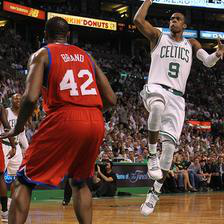

Caption:  Boston� 1971 and” Mag the.. for<s> 12 as Mass a Carm<s><s>


In [19]:
#@title Inference
checkpoint = torch.load("./checkpoint/checkpoint_ClipNews.pth.tar")
ImageEncoder = checkpoint['ImageEncoder']
enc_text = checkpoint['enc_text']
dec = checkpoint['dec']
model = checkpoint['model']
best_cider = checkpoint['cider']
recent_cider = best_cider
optimizer = optim.Adam(model.parameters(), lr=0.0005)
encoder_optimizer = checkpoint['encoder_optimizer']
# Moving model to GPU
ImageEncoder = ImageEncoder.to(device)
enc_text = enc_text.to(device)
dec = dec.to(device)
model = model.to(device)

# Defining loss function
criterion = nn.CrossEntropyLoss().to(device)

model.eval()  # eval mode (no dropout or batchnorm)
# Compute the predictions for the inputs
caplens = [20]
prediction = translate_sentence(model, arts_ids, arts_mask, arts_emb, caplens, imgs, device)
img = Image.open(image_dir+testdata[idx]["image_path"])
img.show()
print("Caption:", prediction)